In [1]:
! apt install tesseract-ocr
! apt install libtesseract-dev
! pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libtesseract-dev is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#import packages
import pytesseract
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
import re
import os
import shutil
from google.colab import drive
import datetime


In [24]:
#this will connect to your Google Drive. It will ask you to allow access
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [121]:
# create a file list data frame to keep the old-name -> new-name conversions and status 
file_names_list = []

In [122]:
def unzip_src(folder):
  """
  Unzip zipped folder.

  A zipped folder is taken in and unzipped.

  Parameter
  ---------
  kind : Google Drive Folder
    Folder containing watershed photos.

  Returns
  -------
  new_src : new src for unzipped folder.
  unzipped : unzipped folder.

  """
  new_src = folder
  unzipped = None

  if folder[-4:] == '.zip':
    src_as_zip = True
    unzipped = folder[:-4]
    shutil.unpack_archive(folder, unzipped)

    parentZip = np.array(os.listdir(unzipped))
    new_src = unzipped + '/' + parentZip[0]
  
  return new_src, unzipped


def new_folder(src, dst = None):
  '''
  Create a new folder destination address for folder to be copied.

  This method's parameter is the address of folder you're going to copy, address of destination parent folder
  It will return the name of folder (to use later), full new address of copy folder 
  determines new folder address.

  Parameters
  ----------
  src : src address for folder to be copied.
  dst : destination address for folder to be copied.

  Returns
  -------
  folder_name : the new folders name.
  newAddress : the full new address of copy folder.
  '''
  if dst is None:
    dst = src
  # print(src, "Src")
  src_elements = src.split('/')
  folder_name = src_elements[-1][:2]
  # print(folder_name, "Folder")
  newAddress = dst + "/" + folder_name
  return folder_name, newAddress


def generate_picName(fdr_name, tStamp):
  '''
  Generate standardized picture names.

  The full source address of a pciture file and its time stamp are standardized 
  to a format delineated by water shed number and time stamp. 

  Parameters
  ----------
  fdr_name : full source address of current picture file.
  tStamp : unaltered timeStamp from bottom of the photo
      as a string.

  Returns
  -------
  new_name : new name of picture
  '''
  ws_num = fdr_name[1] #!!!this should be changed if src_elements[-2][1] will not be watershed number!!

  stamp_elements = re.split('[\n: -]', tStamp)
  date = stamp_elements[2] + stamp_elements[0] + stamp_elements[1]
  time = stamp_elements[3] + stamp_elements[4] + stamp_elements[5]

  new_name = "Hbwtr_w" + ws_num + '_' + date + '_' + time + '.JPG'
  return new_name

def extract_timeStamp(pic_address):
    '''
    Extract time Stamp from picture file.

    From the bottom right of each picture file, the time stamp is read as image using cv2. It is then converted to a string.
    text which is then checked for format and subsequently returned through match_date_format.

    Parameters
    ----------
    pic_address : full source address of current picture file.
    Returns
    -------
    match_date_format.group(0) : unaltered timeStamp from bottom of the photo as a string.
    '''
    # print(pic_address)
    img = cv2.imread(pic_address) #read as an image
    ts = img[2352:, 2000:, :] #(change if sizing conventions change!)
    text = pytesseract.image_to_string(ts)
    print(text)
    # check if the timestamp is the correct format
    date_pattern = "\d\d-\d\d-\d\d\d\d \d\d:\d\d:\d\d" # eg 12-12-2020 11:59:32
    match_date_format = re.search(date_pattern,text)
    if not match_date_format:
      print("Correct timestamp not found")
    else:
      return match_date_format.group(0)

def rename_images(picFolder, fdr_name, fdr_dst):

  '''
  Rename all files in the current folder and populate the list of old and new names.

  For each picture file in the current folder, its filename is changed and its new name is generated in another method.
  The old image is copied to its new destination.

  Parameters
  ----------
  picFolder : a folder containing pictures.
  fdr_name : full address of folder.
  fdr_dst : full destination address.
  '''

  picFiles = np.array(os.listdir(picFolder))
  # print(picFiles, len(picFiles))
  old_folder = "/".join(picFolder.split("/")[-3:-1])

  for filename in picFiles:
    old_name = filename
    new_name = np.nan
    status="raw"
    note = np.nan
    print("Old filename", filename) #just to track where you are
    src = picFolder + '/' + filename #old img address
    # print(src)
    filetype = filename[-4:]
    try:
      if (filetype == '.JPG') or (filetype == '.jpg'):
        tStamp = extract_timeStamp(src)
        new_name = generate_picName(fdr_name, tStamp)
        print("New filename", new_name)
        status = "renamed"
        dst = fdr_dst + '/' + filename #new img address
        dst_renamed = fdr_dst + '/' + new_name #img new address + name
        shutil.copy(src, dst_renamed) #copies old image to new destination

        # os.rename(src, dst) #renames file in Google Drive
      else:
        print("Not image file")
        status= "error"
        note = "Not image file"
    except:
      print("Unable to process file")
      status = "error"
      note =  "Unable to process file"
    curr_list = [old_name, new_name, status, note, picFolder]
    file_names_list.append(curr_list)



In [123]:
# MAIN

from glob import glob

#collect all folder paths from newly uploaded data on folder
folder_list = glob("/content/drive/MyDrive/2_Camera Trap photos/COPY of data for script/Newly_uploaded_data/*/", recursive = True)
# collect all folder path from on deck folder
folder_list.extend(glob("/content/drive/MyDrive/2_Camera Trap photos/COPY of data for script/On_Deck/*/", recursive = True))

# extract folder_name 
folder_list = [f[:-1] for f in folder_list]

# for each folder rename and add them to the new destination - dst
for folder in folder_list:
  dst = "/content/drive/MyDrive/2_Camera Trap photos/COPY of data for script/Testing destination"
  save_as_zip = False

  #will unzip if necessary
  folder, unzipped = unzip_src(folder)

  # #create new destination folder
  fdr_name, fdr_dst = new_folder(folder, dst)

  if os.path.exists(fdr_dst):
    print("path already exists")
  else:
    print("new path")
    os.mkdir(fdr_dst)

  rename_images(folder, fdr_name, fdr_dst)

path already exists
Old filename 05100001.JPG
05-10-2021 11:59:49

New filename Hbwtr_w3_20210510_115949.JPG
Old filename 05110003.JPG
05-11-2021 11:59:48

New filename Hbwtr_w3_20210511_115948.JPG
Unable to process file
Old filename 05120005.JPG
05-12-2021 11:59:48

New filename Hbwtr_w3_20210512_115948.JPG
Unable to process file
Old filename 05130008.JPG
05-13-2021 11:59:47

New filename Hbwtr_w3_20210513_115947.JPG
Unable to process file
Old filename 05140011.JPG
05-14-2021 11:59:47

New filename Hbwtr_w3_20210514_115947.JPG
Unable to process file
Old filename 05150013.JPG
05-15-2021 11:59:46

New filename Hbwtr_w3_20210515_115946.JPG
Unable to process file
Old filename 05160015.JPG
05-16-2021 11:59:46

New filename Hbwtr_w3_20210516_115946.JPG
Unable to process file
Old filename 05170018.JPG
05-17-2021 11:59:45

New filename Hbwtr_w3_20210517_115945.JPG
Unable to process file
Old filename 05180020.JPG
05-18-2021 11:59:45

New filename Hbwtr_w3_20210518_115945.JPG
Unable to

In [125]:
# file_list data frame
file_df = pd.DataFrame(file_names_list, columns = ["old_name", "new_name","status", "note","old_folder"])
file_df

old_name                      new_name   status  \
0    05100001.JPG  Hbwtr_w3_20210510_115949.JPG  renamed   
1    05110003.JPG  Hbwtr_w3_20210511_115948.JPG    error   
2    05120005.JPG  Hbwtr_w3_20210512_115948.JPG    error   
3    05130008.JPG  Hbwtr_w3_20210513_115947.JPG    error   
4    05140011.JPG  Hbwtr_w3_20210514_115947.JPG    error   
..            ...                           ...      ...   
872  01190387.JPG  Hbwtr_w2_20190119_115812.JPG  renamed   
873  01270406.JPG  Hbwtr_w2_20190127_120450.JPG  renamed   
874  02020417.JPG  Hbwtr_w2_20190202_115933.JPG  renamed   
875  01220394.JPG  Hbwtr_w2_20190122_115803.JPG  renamed   
876   desktop.ini                           NaN    error   

                       note                                         old_folder  
0                       NaN  /content/drive/MyDrive/2_Camera Trap photos/CO...  
1    Unable to process file  /content/drive/MyDrive/2_Camera Trap photos/CO...  
2    Unable to process file  /content/drive/MyDrive/2_Camera Trap photos/CO...  
3    Unable to process file  /content/drive/MyDrive/2_Camera Trap photos/CO...  
4    Unable to process file  /content/drive/MyDrive/2_Camera Trap photos/CO...  
..                      ...                                                ...  
872                     NaN  /content/drive/MyDrive/2_Camera Trap photos/CO...  
873                     NaN  /content/drive/MyDrive/2_Camera Trap photos/CO...  
874                     NaN  /content/drive/MyDrive/2_Camera Trap photos/CO...  
875                     NaN  /content/drive/MyDrive/2_Camera Trap photos/CO...  
876          Not image file  /content/drive/MyDrive/2_Camera Trap photos/CO...  

[877 rows x 5 columns]

In [126]:
# files with error status
file_df[file_df.status=="error"]

old_name                      new_name status  \
1    05110003.JPG  Hbwtr_w3_20210511_115948.JPG  error   
2    05120005.JPG  Hbwtr_w3_20210512_115948.JPG  error   
3    05130008.JPG  Hbwtr_w3_20210513_115947.JPG  error   
4    05140011.JPG  Hbwtr_w3_20210514_115947.JPG  error   
5    05150013.JPG  Hbwtr_w3_20210515_115946.JPG  error   
..            ...                           ...    ...   
356   desktop.ini                           NaN  error   
425   desktop.ini                           NaN  error   
427   desktop.ini                           NaN  error   
604   desktop.ini                           NaN  error   
876   desktop.ini                           NaN  error   

                       note                                         old_folder  
1    Unable to process file  /content/drive/MyDrive/2_Camera Trap photos/CO...  
2    Unable to process file  /content/drive/MyDrive/2_Camera Trap photos/CO...  
3    Unable to process file  /content/drive/MyDrive/2_Camera Trap photos/CO...  
4    Unable to process file  /content/drive/MyDrive/2_Camera Trap photos/CO...  
5    Unable to process file  /content/drive/MyDrive/2_Camera Trap photos/CO...  
..                      ...                                                ...  
356          Not image file  /content/drive/MyDrive/2_Camera Trap photos/CO...  
425          Not image file  /content/drive/MyDrive/2_Camera Trap photos/CO...  
427          Not image file  /content/drive/MyDrive/2_Camera Trap photos/CO...  
604          Not image file  /content/drive/MyDrive/2_Camera Trap photos/CO...  
876          Not image file  /content/drive/MyDrive/2_Camera Trap photos/CO...  

[224 rows x 5 columns]

In [127]:
# files unable to process
file_df[file_df.note=="Unable to process file"]

old_name                      new_name status  \
1    05110003.JPG  Hbwtr_w3_20210511_115948.JPG  error   
2    05120005.JPG  Hbwtr_w3_20210512_115948.JPG  error   
3    05130008.JPG  Hbwtr_w3_20210513_115947.JPG  error   
4    05140011.JPG  Hbwtr_w3_20210514_115947.JPG  error   
5    05150013.JPG  Hbwtr_w3_20210515_115946.JPG  error   
..            ...                           ...    ...   
302  03200273.JPG                           NaN  error   
311  03290291.JPG                           NaN  error   
319  04060307.JPG                           NaN  error   
341  04270352.JPG                           NaN  error   
350  05060371.JPG                           NaN  error   

                       note                                         old_folder  
1    Unable to process file  /content/drive/MyDrive/2_Camera Trap photos/CO...  
2    Unable to process file  /content/drive/MyDrive/2_Camera Trap photos/CO...  
3    Unable to process file  /content/drive/MyDrive/2_Camera Trap photos/CO...  
4    Unable to process file  /content/drive/MyDrive/2_Camera Trap photos/CO...  
5    Unable to process file  /content/drive/MyDrive/2_Camera Trap photos/CO...  
..                      ...                                                ...  
302  Unable to process file  /content/drive/MyDrive/2_Camera Trap photos/CO...  
311  Unable to process file  /content/drive/MyDrive/2_Camera Trap photos/CO...  
319  Unable to process file  /content/drive/MyDrive/2_Camera Trap photos/CO...  
341  Unable to process file  /content/drive/MyDrive/2_Camera Trap photos/CO...  
350  Unable to process file  /content/drive/MyDrive/2_Camera Trap photos/CO...  

[215 rows x 5 columns]

file_exists: True


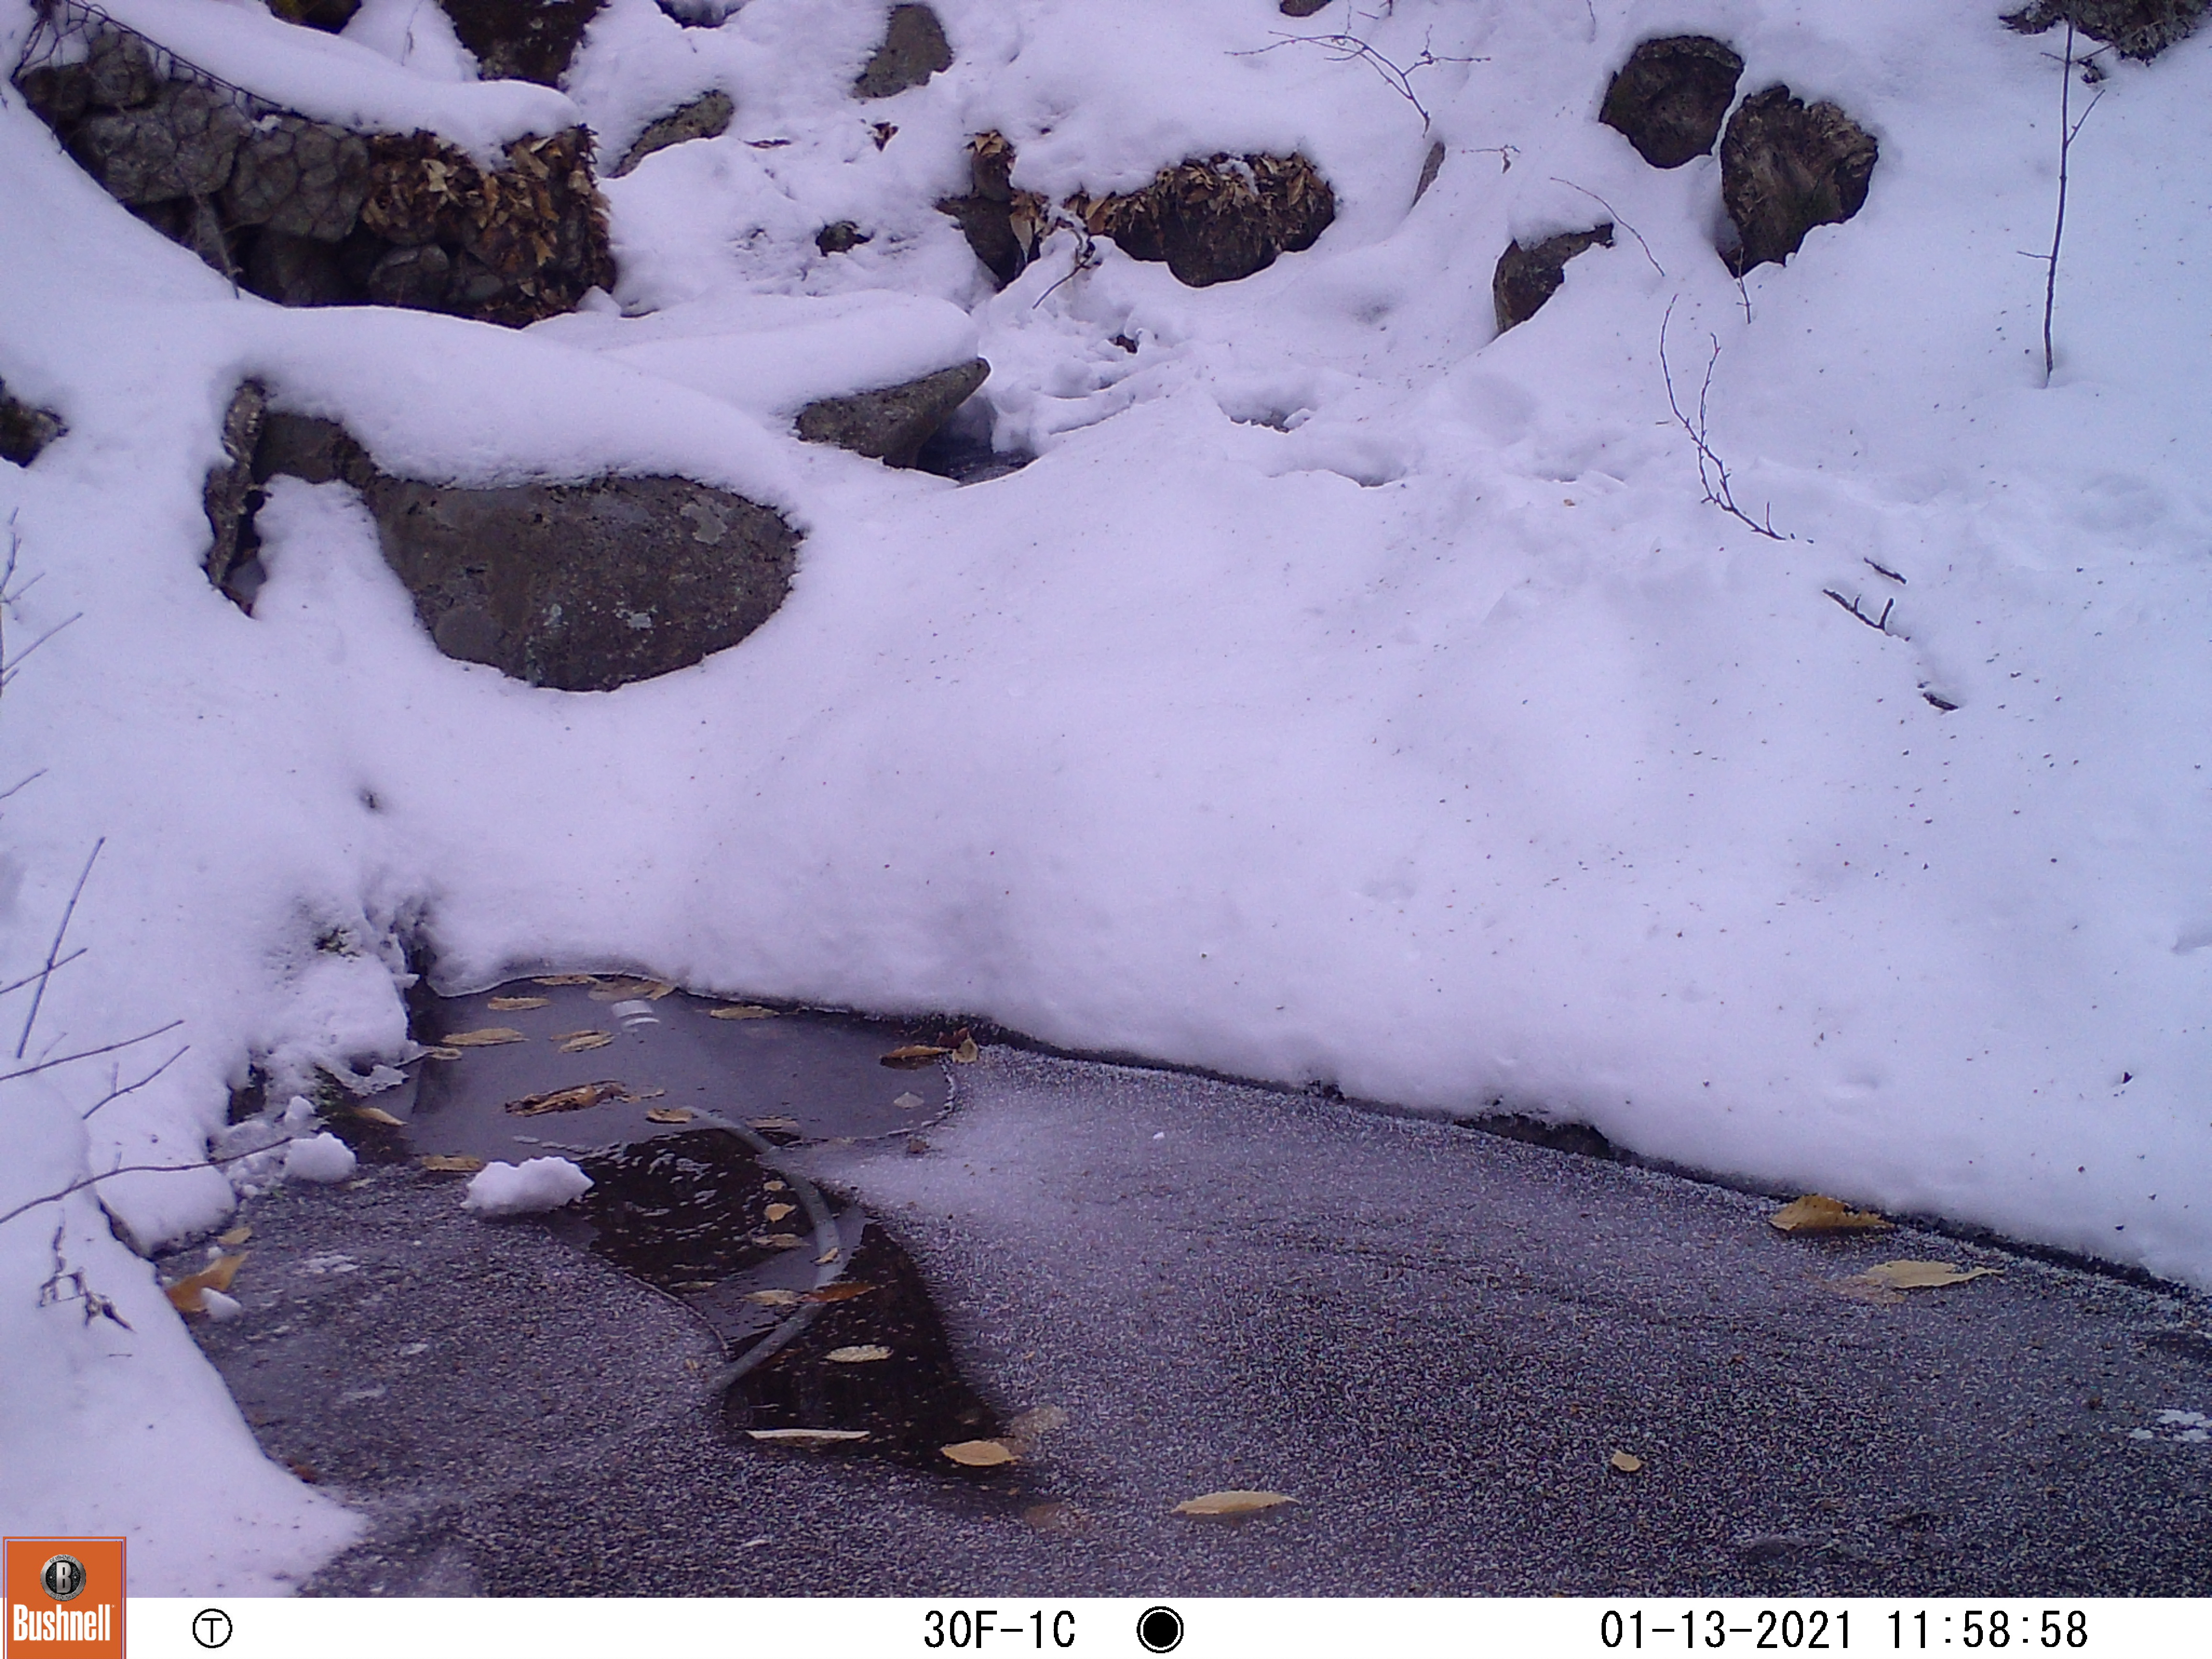

In [128]:
# View images not processed
from os.path import exists
from IPython.display import Image
path = "/content/drive/MyDrive/2_Camera Trap photos/COPY of data for script/Newly_uploaded_data/W1 GC Channel 11-7-20  thru 5-9-21/01130140.JPG"
file_exists = exists(path)
print("file_exists:" , file_exists)
Image(path)

In [129]:
extract_timeStamp(path)

"58

oO
LoD
™
_
_
NI
©
n
0)
_
|
—
©

 

Correct timestamp not found
